Repository: https://github.com/matteo-torres/thomas-fire-analysis

## About
The Thomas Fire, which affected both Santa Barbara and Ventura counties in December 2017, is historically significant as one of the largest fires in that time period. The fire was ignited by high winds that caused power lines to touch, creating an electrical arc that deposited molten material onto the ground, igniting nearby vegetation. In total, the fire burned 281,893 acres, destroyed 1,063 structures, and resulted in two fatalities—a firefighter and a civilian. Additionally, the Thomas Fire caused long-term environmental impacts, resulting in widespread ecological damage and the displacement of communities.

## Highlights
- Analyze both the daily and 5-day average Air Quality Index (AQI)
- Explore the landscape using remote sensing techniques
- Visualize the fire scar with a false-color image

## Data Descriptions
The California Fire Perimeter and Prescribed Fire Database provides spatial data on historical wildfires and prescribed burns dating back to 1878. This database is maintained by several agencies, including CAL FIRE, the USDA Forest Service, and the National Park Service.

The Landsat Collection 2 Level-2 dataset includes atmospherically corrected surface reflectance and temperature image data. This dataset, collected from the Landsat 8 satellite, has been pre-processed to exclude data outside land areas. It also features a coarser spatial resolution and a simplified collection of bands.

The daily Air Quality Index (AQI) datasets from the U.S. Environmental Protection Agency establish an AQI for five major air pollutants that are regulated by the Clean Air Act. This index serves as a tool for communicating information about outdoor air quality and its effects on health.

## Analyze the AQI of 2017

First, it is essential that we import the necessary Python libraries. For this analysis, we will be using the `pandas` library for data manipulation.

In [1]:
import pandas as pd

Now, we can read the datasets, saved as CSV files, using the `pandas` command `pd.read_csv` and assign them to a concise variable name.

In [2]:
aqi_17 = pd.read_csv("data/daily_aqi/daily_aqi_by_county_2017.zip", compression = "zip")
aqi_18 = pd.read_csv("data/daily_aqi/daily_aqi_by_county_2018.zip", compression = "zip")

By setting the compression argument to "zip," `pandas` will first decompress the zip file and then create a DataFrame from the CSV file contained within the zipped file. The datasets are named according to their corresponding year.

Next, it is important to combine both dataframes to analyze the Air Quality Index (AQI) of the Thomas Fire, which started in 2017 and continued into early 2018. In this case, we can simply place the 2017 dataset on top of the 2018 dataset using the `pandas` command `pd.concat`.

In [3]:
aqi = pd.concat([aqi_17, aqi_18])

Now that we have a single DataFrame with all the AQI data, we can clean it up by:
1. Simplifying the column names

In [4]:
aqi.columns = (aqi.columns.str.lower().str.replace(' ','_'))

2. Filtering the data to include only Santa Barbara County

In [5]:
aqi_sb = aqi[aqi["county_name"] == "Santa Barbara"]

3. Removing any unnecessary columns 

In [6]:
aqi_sb = aqi_sb.loc[:, "date":"number_of_sites_reporting"]

4. Ensuring that all variables have the correct data types

In [7]:
aqi_sb["date"] = pd.to_datetime(aqi_sb["date"])

5. Indexing and arranging the data in chronological order

In [8]:
aqi_sb = aqi_sb.set_index("date").sort_index()

The output should produce a DataFrame that is ready for analysis. Since we want to examine AQI throughout 2017, we need to consider both the daily AQI values and the 5-day AQI averages. To achieve this, we will create a new column for the 5-day averages. By applying a rolling mean to calculate them, we can effectively analyze and identify trends in the time series.

In [9]:
aqi_sb["five_day_average"] = aqi_sb["aqi"].rolling(window = "5D").mean()

Finally, we can plot both the daily and 5-day average AQI to analyze how air quality has changed over time and to visualize the effect of the Thomas Fire that occurred at the end of 2017.

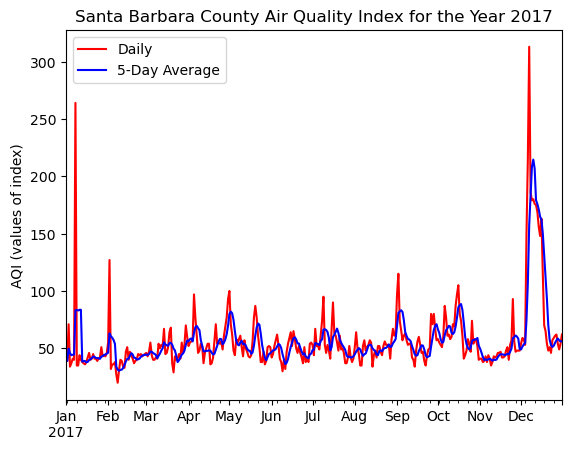

In [28]:
ax = aqi_sb.loc["2017"].plot(y = ["aqi", "five_day_average"],
                             xlabel = " ",
                             ylabel = "AQI (values of index)",
                             title = "Santa Barbara County Air Quality Index for the Year 2017",
                             kind = "line",
                             color=["red", "blue"])

ax.legend(["Daily", "5-Day Average"])

fig = ax.get_figure()  # Get the Matplotlib figure object
fig.savefig("sb_aqi_2017_plot.png", dpi=300, bbox_inches="tight")

## Visualize the Fire Scar with a False-Color Image

Again, it is essential that we begin by importing the necessary Python libraries. We will be using the `os` library to manage file pathways, the `geopandas` library for handling geospatial data, the `rioxarray` library for working with raster data, and `matplotlib.pyplot` for creating visualizations.

In [11]:
import os
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

Now, we will import the datasets, which include the shapefile for the Thomas Fire area and the Landsat 8 raster data.

In [12]:
data_dir = os.path.join(os.getcwd(), "data")

thomas_fire = gpd.read_file(os.path.join(data_dir, "thomas_fire", "thomas_fire.shp"))
landsat = rioxr.open_rasterio(os.path.join(data_dir, "landsat", "landsat8-2018-01-26-sb-simplified.nc"))

Before using the Landsat raster, it is important to remove the band dimension, as it does not match the length of the x and y dimensions.

In [13]:
landsat = landsat.squeeze().drop_vars("band")

We can now visualize the vegetation health of Santa Barbara County using a false-color image. By utilizing the shortwave infrared, near-infrared, and red bands, we can clearly highlight areas with poor vegetation health.

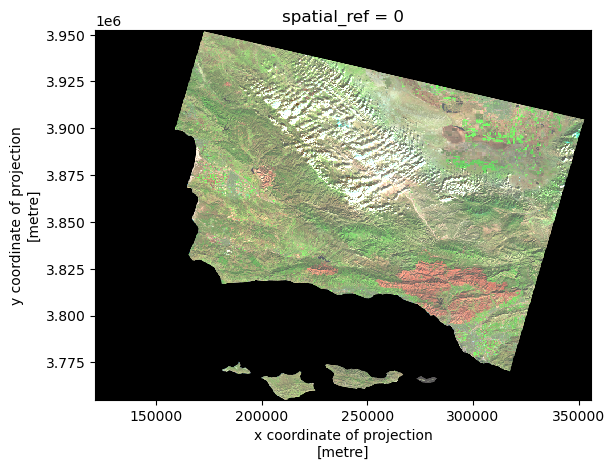

In [14]:
landsat[["swir22", "nir08", "red"]].to_array().plot.imshow(robust = True)

To assess how the fire may have affected vegetation health, it is essential to overlay the Thomas Fire shapefile onto the false-color image. However, we first need to ensure that both datasets use the same coordinate reference system.

In [15]:
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

We must also ensure that there is a proportional relationship between an image's width and height, maintaining its aspect ratio.

In [16]:
aspect_ratio = landsat.rio.width/landsat.rio.height

To closely examine the impact of vegetation, we should crop the raster to fit within the boundaries of the Thomas fire.

In [17]:
landsat_clip = landsat.rio.clip_box(*thomas_fire.total_bounds)

Finally, we can now create a map that overlays the shapefile perimeter on the false-color raster. This will help us more clearly examine the fire scar left by the Thomas Fire in 2017.

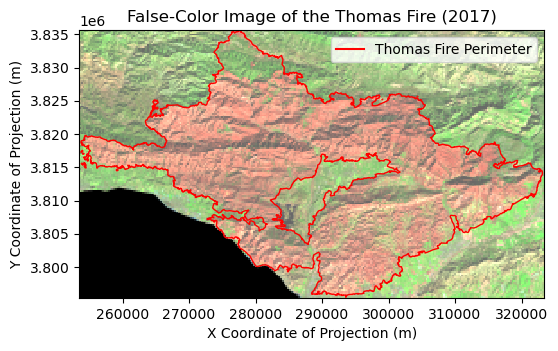

In [25]:
fig, ax = plt.subplots(figsize = (6, 6 * aspect_ratio))

landsat_clip[["swir22", "nir08", "red"]].to_array().plot.imshow(robust = True)

thomas_fire.plot(ax = ax, 
                 facecolor = "none", 
                 edgecolor = "red", 
                 linewidth = 1)

ax.set_title("False-Color Image of the Thomas Fire (2017)")
ax.set_xlabel("X Coordinate of Projection (m)")
ax.set_ylabel("Y Coordinate of Projection (m)")
legend_elements = [Line2D([0], [0], 
                          color = "red", 
                          lw = 1.5, 
                          label = "Thomas Fire Perimeter")]
ax.legend(handles = legend_elements)

plt.show()

## Final Visualizations

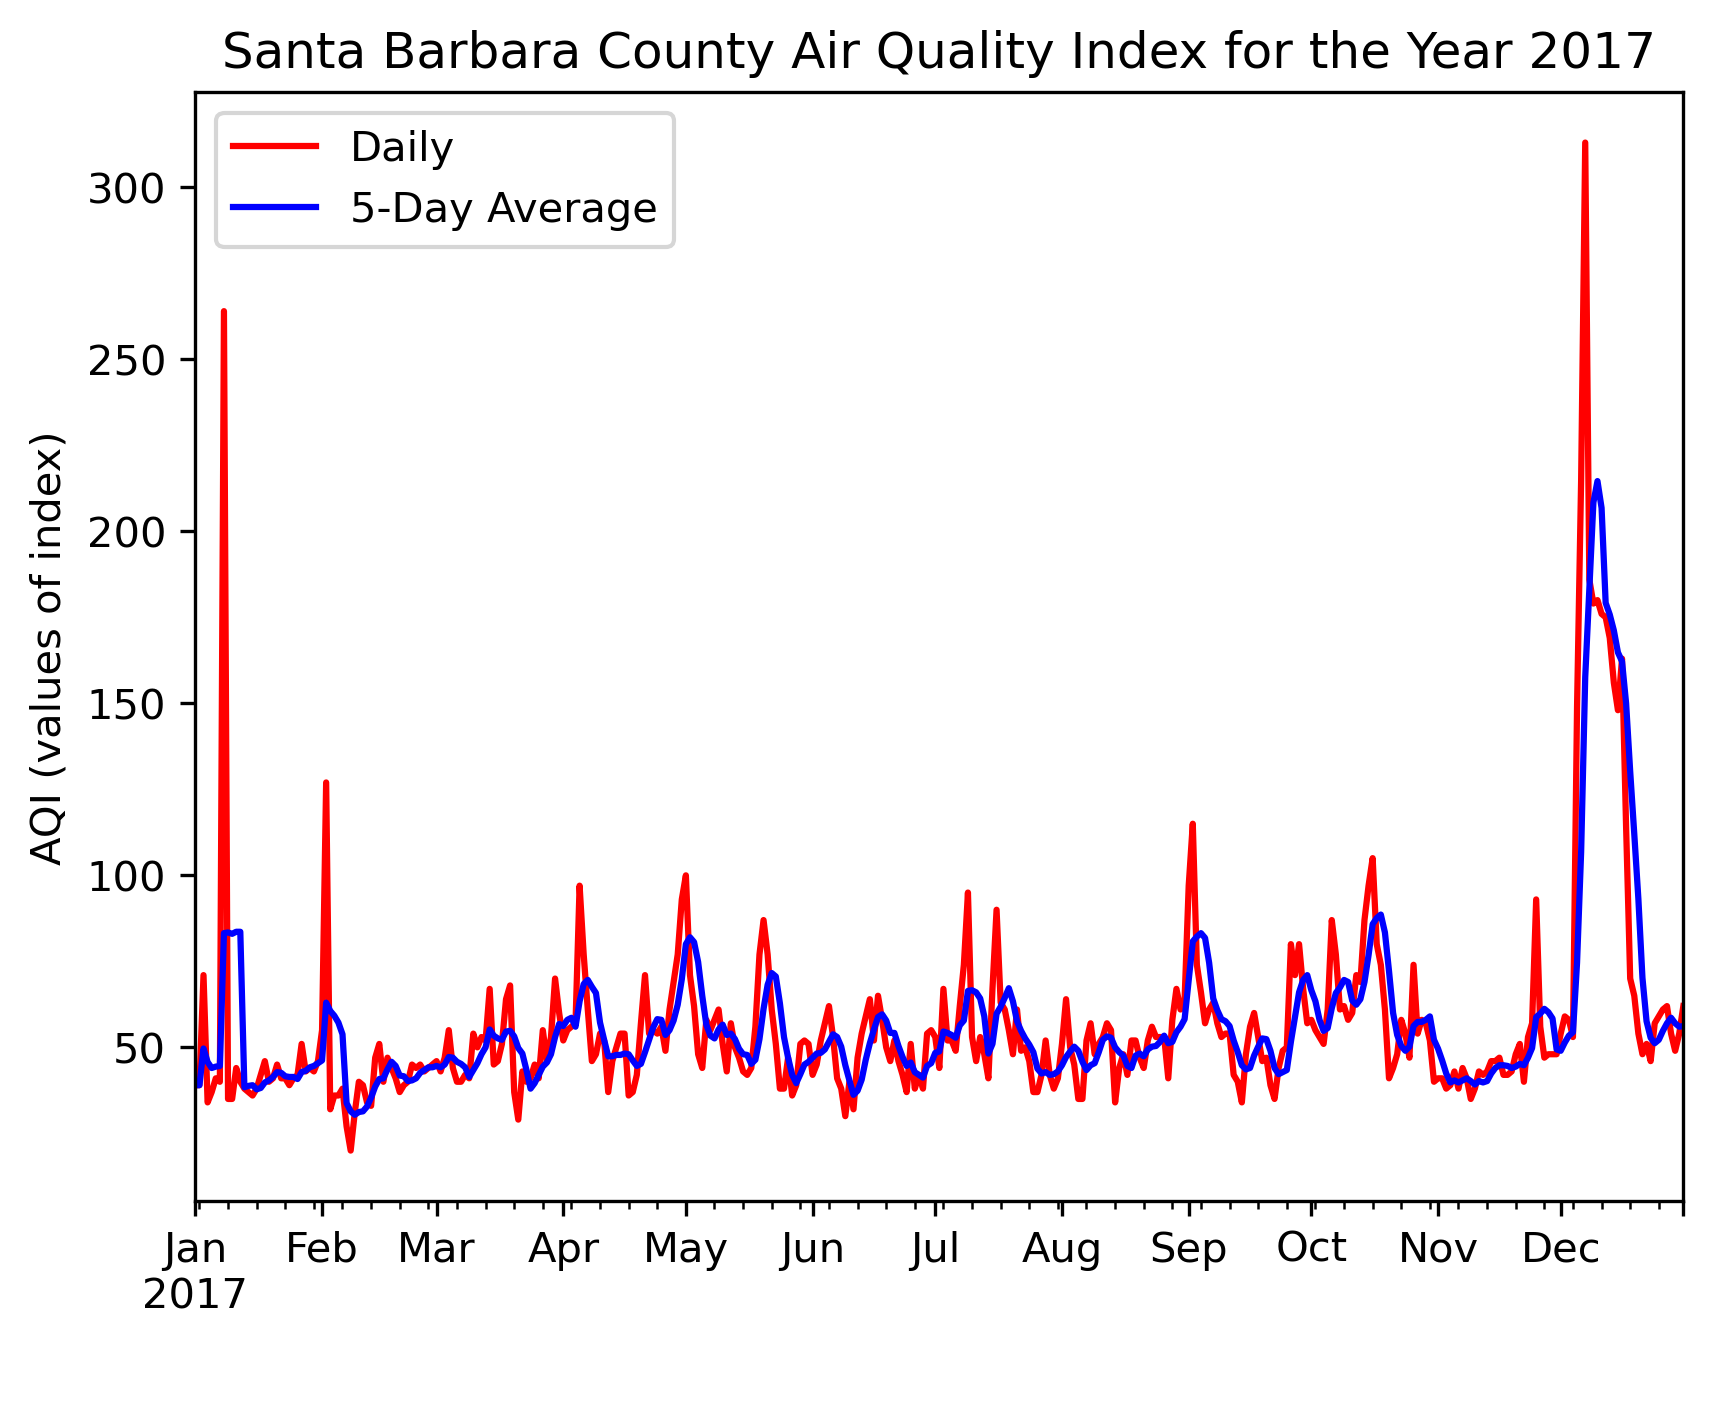

The plot illustrates the Air Quality Index (AQI) in Santa Barbara throughout 2017. At the end of the year, both the daily and 5-day average AQIs show a significant spike in December, coinciding with the occurrence of the Thomas fire. This demonstrates how the Thomas fire contributed to poorer air quality, which likely impacted local communities.

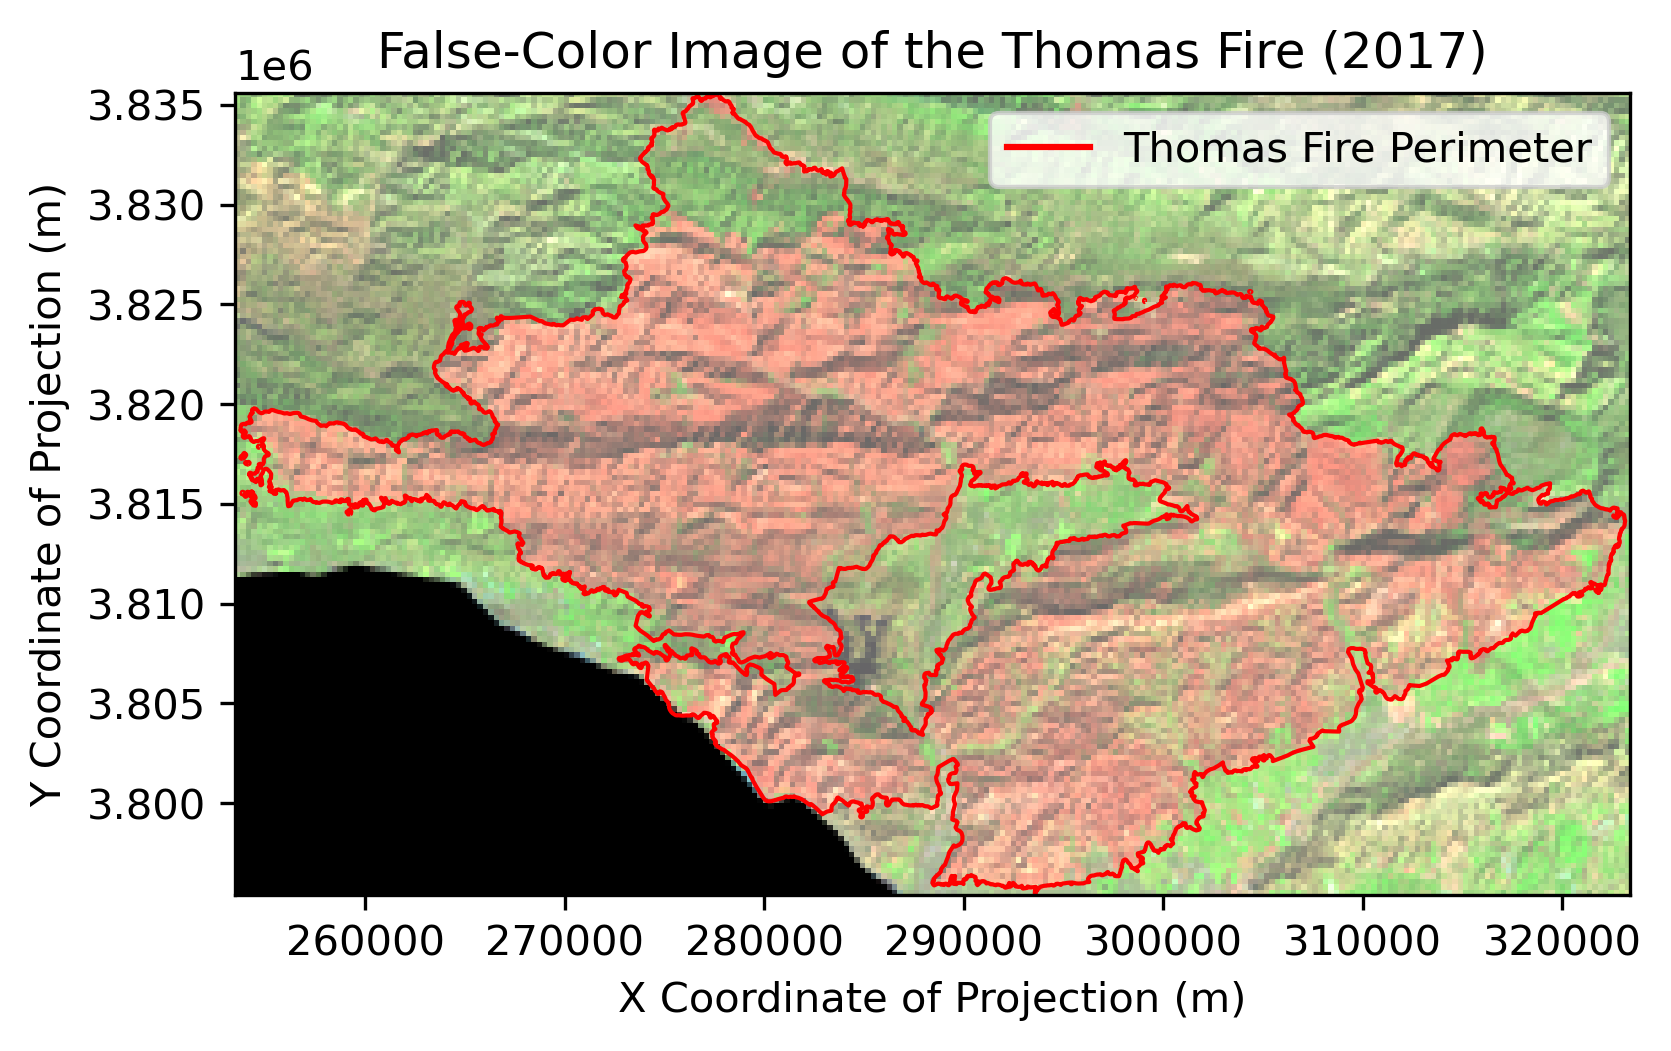

The map illustrates the effects of the Thomas Fire, which occurred in 2017. The false color image (using shortwave infrared, near-infrared, and red wavelengths) highlights areas of the burn scar on vegetation in red. In this imagery, green is typically used to assess vegetation health and density; the brighter or more vivid the green, the healthier and denser the vegetation appears.

## Data References
California Department of Forestry and Fire Protection. (n.d.). California fire perimeters (all) [Dataset]. Data.gov. Retrieved from https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436

Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [Dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6

United States Environmental Protection Agency. (2024). Daily AQI by County [Dataset]. EPA. Retrieved from https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI